In [1]:
import torch
import torch.nn as nn
import torch.distributions as D
from sklearn.datasets import make_moons
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from tqdm import tqdm
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
import numpy as np

RealNVP - генеративная модель глубокого обучения, основанная на нормализующих потоках. Нормализующий поток выполняет задачу отображения сэмпла данных из некоторого простого распределения (удобного для сэмплирования - например, нормального) в более сложное, которое мы и хотим научиться моделировать. Кроме того, поток поддерживает и обратное, нормализующее отображение.
Отличием нормализующих потоков от прочих генеративных вероятностных моделей, состоит в точном вычислении функции правдоподобия, которая, в свою очередь, вычисляется с помощью формулы замены переменной.

$$
f_Y(y) = f_X(g^{-1}(y)) \cdot \left|  J^{-1}f_X \right|
$$

Соответственно, необходимо уметь эффективно вычислять якобиан трансофрмации. Ниже представлена реализация модели RealNVP, в основе которой лежит использование функции специального вида, позволяющей простым способом вычислять якобиан.


In [2]:
X, y = make_moons(n_samples=1000, noise=0.05)

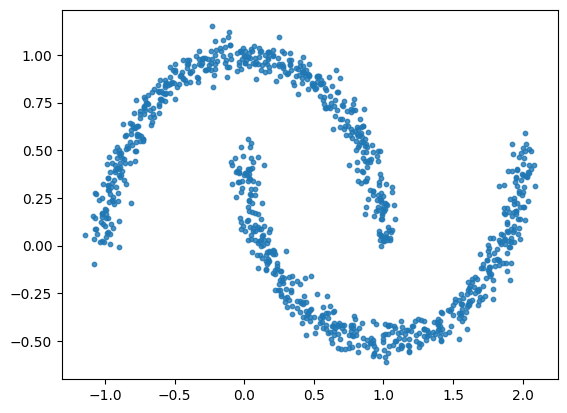

In [3]:
plt.scatter(X[:, 0], X[:, 1], s=10, alpha=0.8)
plt.show()

# Архитектура RealNVP

Основой архитектуры являются блоки **афинного связывания**. Каждый такой блок моделирует функцию отображения из латентного пространства в исследуемое. Функция организована в виде двух нейросетей (scale_net = s, translation_net = t), который действуют на входной тензор (в данной реализации - просто вектор). Изначально, вектор частично маскируется, и только часть выходных каналов будет изменена, остальные останутся шумом. Изменные каналы пройдут через нейронные сети.
Якобиан такой трансформации будет матрицей треугольного вида и легко вычисляем.

$$
y_{1:d} = x_{1:d} \quad (1)
$$

$$
y_{d+1:D} = x_{d+1:D} \cdot \exp(s(x_{1:d})) + t(x_{1:d}) \quad (2)
$$

Обе нейронные сети спроектированы как обычный MLP. В случае если данные - изображения, уместно будет обе сети представить как CNN.

In [4]:
class AffineCoupleLayer(nn.Module):
  def __init__(self, hidden_dim, mask):
    super(AffineCoupleLayer, self).__init__()
    self.mask = mask
    input_dim = len(self.mask)

    # масштабирующая сеть - отвечает за машстабирование каналов вектора - обычный MLP
    self.scale_net = nn.Sequential(
        nn.Linear(input_dim, hidden_dim),
        nn.ReLU(),
        nn.Linear(hidden_dim, hidden_dim * 2),
        nn.ReLU(),
        nn.Linear(hidden_dim * 2, hidden_dim),
        nn.ReLU(),
        nn.Linear(hidden_dim, input_dim),
        nn.ReLU()
    )
    # трасляционная сеть - добавляет к каналам вектора смещение  - обычный MLP
    self.translation_net = nn.Sequential(
        nn.Linear(input_dim, hidden_dim),
        nn.ReLU(),
        nn.Linear(hidden_dim, hidden_dim * 2),
        nn.ReLU(),
        nn.Linear(hidden_dim * 2, hidden_dim),
        nn.ReLU(),
        nn.Linear(hidden_dim, input_dim)
    )

  def forward(self, x):
    mask = self.mask.to(x.device)
    x1 = x * mask #маскируем, чтобы зафиксировать часть, которую не будем менять
    t = self.translation_net(x1)
    s = self.scale_net(x1) * (1 - mask)
    z = x1 + (1 - mask) * (x * torch.exp(s) + t) # латентный вектор образуется конкатенацией неизменяемой части и части, которая претерпела изменения проходя через MLP
    log_det_jacobian = torch.sum(s, dim=1) # якобиан трансформации - произведение единичной матрицы и диагональной
    return z, log_det_jacobian

  # "нормализующий" проход - восстановление латентного вектора
  def backward(self, z):
    mask = self.mask.to(z.device)
    z1 = z * mask
    t = self.translation_net(z1)
    s = self.scale_net(z1) * (1 - mask)
    x = z1 + (1 - mask) * (z - t) * torch.exp(-s)
    log_det_jacobian = torch.sum(s, dim=1)
    return x, log_det_jacobian




Блоки афинного связывания идут последовательно и в каждом применяется своя маска для входных данных - чтобы сделать модель выразительной и обучить моделировать каждый канал.

In [5]:
class RealNVP(nn.Module):
    def __init__(self, num_blocks, hidden_dim, masks):
        super(RealNVP, self).__init__()
        self.dim = len(masks[0])
        self.blocks = nn.ModuleList([AffineCoupleLayer(hidden_dim, masks[i]) for i in range(num_blocks)]) #cсобираем блоки по количеству заданных масок
        self.base_distribution = D.MultivariateNormal(torch.zeros(self.dim).to(device), torch.eye(self.dim).to(device)) # исходный многомерный нормальный шум


    def forward(self, x):
        log_det_jacobian_total = 0
        z = x
        for block in self.blocks:
            z, log_det_jacobian = block(z)
            log_det_jacobian_total += log_det_jacobian
        return z, log_det_jacobian_total

    def inverse(self, z):
        log_det_jacobian_total = 0
        x = z
        for block in reversed(self.blocks):
            x, log_det_jacobian = block.backward(x)
            log_det_jacobian_total += log_det_jacobian
        return x, log_det_jacobian_total

    # кастомная функция для подсчета лосса - как суммы логарифма правдоподобия и лог-детерминанта
    def log_prob(self, x):
        z, log_det_jacobian = self.forward(x)
        log_prob_z = self.base_distribution.log_prob(z)
        return log_prob_z + log_det_jacobian

In [7]:

def train_realnvp(model, num_epochs=2000, lr=1e-4):
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr) # используется обычный Адам - прочие вариации, в том числе AdamW не принесли лучших результатов

    losses = []

    for epoch in tqdm(range(num_epochs)):
      # обучение производится методом семплирования образца на каждой эпохе
        x_train, _ = make_moons(n_samples=1000, noise=0.03) # уровень шума в семплах существенно влияет на качество
        x_train = torch.tensor(x_train, dtype=torch.float32).to(device)
        loss = -(model.log_prob(x_train)).mean() # тут сразу осуществляется форвард и подсчет лог-правдоподобия

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        if epoch % 100 == 0:
            print(f'Epoch [{epoch}/{num_epochs}], Loss: {loss.item():.4f}')

    plt.plot(losses)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss')
    plt.show()




  0%|          | 2/2000 [00:00<05:40,  5.87it/s]

Epoch [0/2000], Loss: 2.5231


  5%|▌         | 102/2000 [00:12<03:25,  9.23it/s]

Epoch [100/2000], Loss: 1.3109


 10%|█         | 202/2000 [00:24<04:53,  6.12it/s]

Epoch [200/2000], Loss: 0.7322


 15%|█▌        | 302/2000 [00:35<04:33,  6.21it/s]

Epoch [300/2000], Loss: 0.6365


 20%|██        | 402/2000 [00:47<02:48,  9.47it/s]

Epoch [400/2000], Loss: 0.4195


 25%|██▌       | 502/2000 [01:01<02:52,  8.70it/s]

Epoch [500/2000], Loss: 0.4116


 30%|███       | 602/2000 [01:13<02:37,  8.88it/s]

Epoch [600/2000], Loss: 0.3952


 35%|███▌      | 702/2000 [01:25<02:27,  8.81it/s]

Epoch [700/2000], Loss: 0.4001


 40%|████      | 802/2000 [01:37<02:17,  8.74it/s]

Epoch [800/2000], Loss: 0.3518


 45%|████▌     | 902/2000 [01:50<02:02,  8.94it/s]

Epoch [900/2000], Loss: 0.3006


 50%|█████     | 1002/2000 [02:03<01:52,  8.83it/s]

Epoch [1000/2000], Loss: 0.3455


 55%|█████▌    | 1102/2000 [02:15<01:40,  8.90it/s]

Epoch [1100/2000], Loss: 0.3307


 60%|██████    | 1202/2000 [02:28<01:38,  8.09it/s]

Epoch [1200/2000], Loss: 0.3407


 65%|██████▌   | 1302/2000 [02:40<01:58,  5.90it/s]

Epoch [1300/2000], Loss: 0.3707


 70%|███████   | 1402/2000 [02:52<01:36,  6.19it/s]

Epoch [1400/2000], Loss: 0.2891


 75%|███████▌  | 1502/2000 [03:04<00:56,  8.88it/s]

Epoch [1500/2000], Loss: 0.2781


 80%|████████  | 1602/2000 [03:21<01:18,  5.06it/s]

Epoch [1600/2000], Loss: 0.3587


 85%|████████▌ | 1702/2000 [03:39<00:38,  7.78it/s]

Epoch [1700/2000], Loss: 0.2932


 90%|█████████ | 1802/2000 [03:53<00:24,  8.04it/s]

Epoch [1800/2000], Loss: 0.3652


 95%|█████████▌| 1902/2000 [04:08<00:11,  8.90it/s]

Epoch [1900/2000], Loss: 0.3042


100%|██████████| 2000/2000 [04:23<00:00,  7.58it/s]


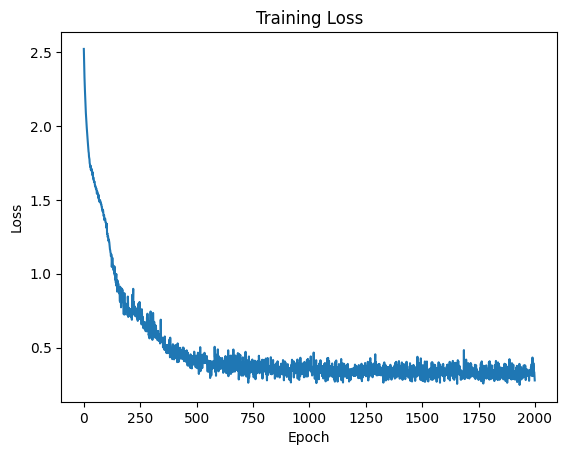

In [8]:
dim = 2
hidden_dim = 128
num_blocks = 8 # число слоев афинного связывания
masks = []
for i in range(num_blocks):
    mask = torch.zeros(dim)
    mask[i % dim] = 1
    masks.append(mask)

model = RealNVP(num_blocks=num_blocks, hidden_dim=hidden_dim, masks=masks)


train_realnvp(model)

In [9]:

def visualize(model, n_samples=512, device="cuda" if torch.cuda.is_available() else "cpu"):
    model.to(device)
    x_new, labels = make_moons(n_samples=n_samples, noise=0.05)
    x_new = torch.tensor(x_new, dtype=torch.float32).to(device)

    # Трансформация в латентное пространство через модель RealNVP
    with torch.no_grad():
        z, _ = model.forward(x_new)

    x_new = x_new.cpu().numpy()
    z = z.cpu().numpy()
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    colors = ['blue', 'green']

    # Исходное пространство
    for label in np.unique(labels):
        ax[0].scatter(x_new[labels == label][:, 0], x_new[labels == label][:, 1], color=colors[label], alpha=0.5, label=f'Class {label}')
    ax[0].set_title('Исходное пространство (make_moons)')
    ax[0].legend()

    # Латентное пространство
    for label in np.unique(labels):
        ax[1].scatter(z[labels == label][:, 0], z[labels == label][:, 1], color=colors[label], alpha=0.5, label=f'Class {label}')
    ax[1].set_title('Латентное пространство (RealNVP)')
    ax[1].legend()

    plt.show()




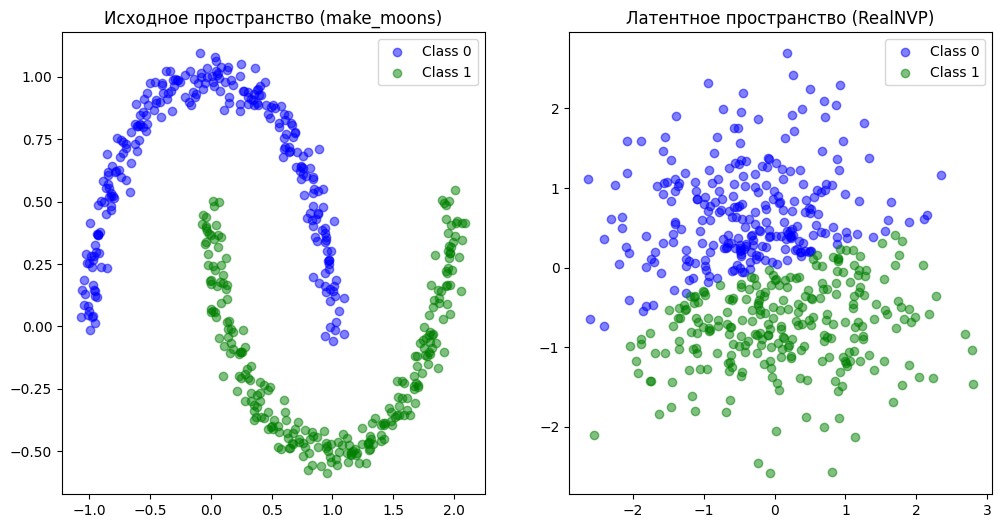

In [ ]:
visualize(model)

In [10]:
def visualize_from_latent(model, n_samples=512, device="cuda" if torch.cuda.is_available() else "cpu"):
    model.to(device)

    # Сэмплирование из нормального распределения
    latent_dim = model.dim
    base_dist = D.MultivariateNormal(torch.zeros(latent_dim).to(device), torch.eye(latent_dim).to(device))
    z_samples = base_dist.sample((n_samples,))

    # Преобразование семпла в исходное пространство через обратный проход модели
    with torch.no_grad():
        x_samples, _ = model.inverse(z_samples)


    z_samples = z_samples.cpu().numpy()
    x_samples = x_samples.cpu().numpy()
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))

    ax[0].scatter(z_samples[:, 0], z_samples[:, 1], color='red', alpha=0.5)
    ax[0].set_title('Сэмплы в латентном пространстве')


    ax[1].scatter(x_samples[:, 0], x_samples[:, 1], color='blue', alpha=0.5)
    ax[1].set_title('Преобразованные сэмплы в исходном пространстве')

    plt.show()



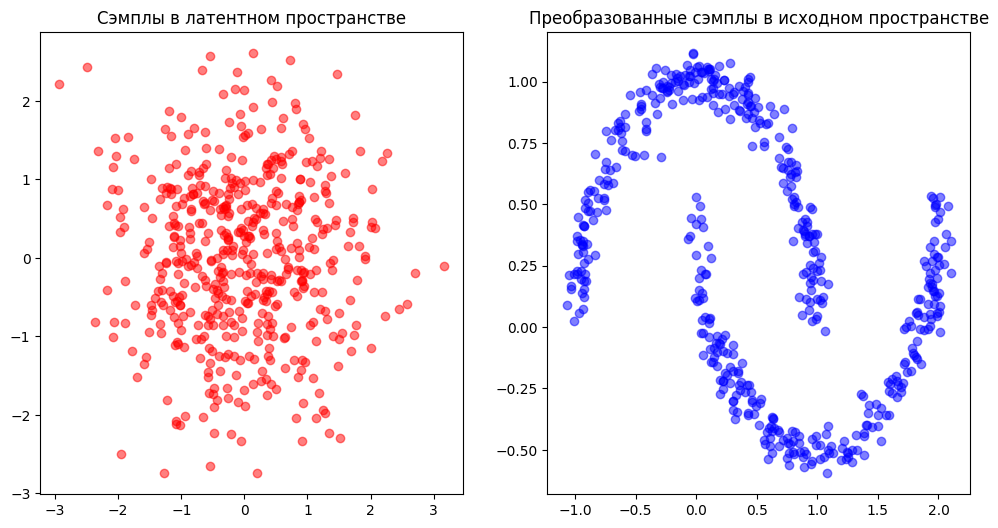

In [11]:
visualize_from_latent(model)

In [12]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
model = RealNVP(num_blocks, hidden_dim, masks)
num_params = count_parameters(model)
print(f'Количество параметров в модели: {num_params}')


Количество параметров в модели: 1064992


В результате получаем достаточно хорошую функцию отображения, которая качественно переводит нормальный шум в нелинейную картину.